In [1]:
import os
import sys
import json
import argparse
import numpy as np
import pandas as pd
import copy
import math
from einops import rearrange
from einops.layers.torch import Rearrange
import time
import random
import h5py
from tqdm import tqdm
import webdataset as wds
import gc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import utils
from models import *
from mindeye_models import *
from accelerate import Accelerator, load_checkpoint_in_model

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

if utils.is_interactive():
    %load_ext autoreload
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2

In [2]:
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

# First use "accelerate config" in terminal for setup
data_type = torch.float16 # change depending on your mixed_precision
num_workers = num_devices = torch.cuda.device_count()
accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
if utils.is_interactive(): # set batch size here if using interactive notebook instead of submitting job
    global_batch_size = batch_size = 6
else:
    global_batch_size = int(os.environ["GLOBAL_BATCH_SIZE"])
    batch_size = int(os.environ["GLOBAL_BATCH_SIZE"]) // num_devices

LOCAL RANK  0


In [3]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
print(accelerator.state)

# set data_type to match your mixed precision
if accelerator.mixed_precision == "bf16":
    data_type = torch.bfloat16
elif accelerator.mixed_precision == "fp16":
    data_type = torch.float16
else:
    data_type = torch.float32

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

PID of this process = 2053243
device: cuda
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float16


# Configuration

In [19]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "mindeye_testing"
    print("model_name:", model_name)
    
    # global_batch_size and batch_size should already be defined in the 2nd cell block
    jupyter_args = f"--model_name={model_name} \
                    --mae_model_name=mae_testing \
                    --nsd_wds_path=/weka/proj-fmri/shared/mindeyev2_dataset/wds \
                    --nsd_raw_path=/weka/proj-fmri/shared/mindeyev2_dataset \
                    --nsd_image_path=/weka/proj-fmri/shared/mindeyev2_dataset \
                    --batch_size={batch_size} \
                    --num_epoch=12 \
                    --num_sessions=10 --in_dim=410112 --hidden_dim=512 \
                    --use_contrastive_loss \
                    --tube_mask_ratio=0.75 --decoder_mask_ratio=0.75 \
                    --num_frames=4 --tubelet_size=1 \
                    --patch_size=8 --frame_patch_size=1 \
                    --max_lr=3e-5 --seed=42 --no-wandb_log --ckpt_saving"

    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: mindeye_testing
--model_name=mindeye_testing                     --mae_model_name=mae_testing                     --nsd_wds_path=/weka/proj-fmri/shared/mindeyev2_dataset/wds                     --nsd_raw_path=/weka/proj-fmri/paulscotti/fMRI-foundation-model/nsd                     --nsd_image_path=/weka/proj-fmri/shared/mindeyev2_dataset                     --batch_size=6                     --num_epoch=12                     --num_sessions=10 --in_dim=410112 --hidden_dim=512                     --use_contrastive_loss                     --tube_mask_ratio=0.75 --decoder_mask_ratio=0.75                     --num_frames=4 --tubelet_size=1                     --patch_size=8 --frame_patch_size=1                     --max_lr=3e-5 --seed=42 --no-wandb_log --ckpt_saving
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument("--model_name", type=str, default="testing",
                    help="name of model, used for ckpt saving and wandb logging (if enabled)")
parser.add_argument("--mae_model_name", type=str, default="mae_test",
                    help="name of pretrained foundation model folder in ../ckpts/")
parser.add_argument("--nsd_wds_path", type=str, default="/weka/proj-fmri/shared/mindeyev2_dataset/wds",
                    help="path to folder containing wds folder for mindeyev2, downloaded from huggingface")
parser.add_argument("--nsd_raw_path", type=str, default="/weka/proj-fmri/shared/mindeyev2_dataset",
                    help="path to folder containing raw subj01 NSD data, downloaded from huggingface")
parser.add_argument("--nsd_image_path", type=str, default="/weka/proj-fmri/shared/mindeyev2_dataset",
                    help="path to folder containing coco_images_224_float16.hdf5, downloaded from huggingface")
parser.add_argument("--batch_size", type=int, default=4)
parser.add_argument("--in_dim", type=int, default=786944)
parser.add_argument("--hidden_dim", type=int, default=512)
parser.add_argument("--drop", type=float, default=.15,
                    help="amount of dropout to use in BrainNetwork")
parser.add_argument("--mixup_pct", type=float, default=0.33)
parser.add_argument("--num_sessions", type=int, default=10,
                    help="training MindEyeV2 on how many sessions/hours of subj01 data")
parser.add_argument("--num_epochs",type=int,default=12,
                    help="number of epochs of training")
parser.add_argument("--num_samples_per_epoch",type=int,default=512)
parser.add_argument("--tube_mask_ratio",type=float,default=0.75)
parser.add_argument("--decoder_mask_ratio",type=float,default=0.75)
parser.add_argument("--num_frames",type=int,default=4)
parser.add_argument("--tubelet_size",type=int,default=1)
parser.add_argument("--patch_size",type=int,default=8)
parser.add_argument("--frame_patch_size",type=int,default=1)
parser.add_argument("--use_contrastive_loss",action=argparse.BooleanOptionalAction,default=True)
parser.add_argument("--use_cls_token",action=argparse.BooleanOptionalAction,default=True)
parser.add_argument("--ckpt_saving",action=argparse.BooleanOptionalAction,default=True)
parser.add_argument("--ckpt_interval",type=int,default=5,
                    help="save ckpt every x epochs")
parser.add_argument("--seed",type=int,default=42)
parser.add_argument("--max_lr",type=float,default=3e-4)
parser.add_argument("--wandb_log",action=argparse.BooleanOptionalAction,default=False,
                    help="whether to log to wandb")
parser.add_argument("--wandb_project",type=str,default="stability",
                    help="wandb project name")

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

print("model_name", model_name)

outdir = os.path.abspath(f'../ckpts/{model_name}')
print("outdir", outdir)

print("global_batch_size", global_batch_size)

use_cls_token = True if use_contrastive_loss else use_cls_token
print("use_cls_token", use_cls_token)

img_size = (64, 64, 48)
print("img_size", img_size)

num_patches = int(
    (img_size[0] / patch_size)
    * (img_size[1] / patch_size)
    * (img_size[2] / patch_size)
    * num_frames
)
num_patches_per_timepoint = num_patches // num_frames
num_encoder_patches = int(num_patches_per_timepoint * (1 - tube_mask_ratio) * num_frames)
num_decoder_patches = int(num_patches_per_timepoint * (1 - decoder_mask_ratio) * num_frames)
print("num_patches", num_patches)
print("num_encoder_patches", num_encoder_patches)
print("num_decoder_patches", num_decoder_patches)

model_name mindeye_testing
outdir /weka/proj-fmri/paulscotti/fMRI-foundation-model/ckpts/mindeye_testing
global_batch_size 6
use_cls_token True
img_size (64, 64, 48)
num_patches 1536
num_encoder_patches 384
num_decoder_patches 384


# Load pretrained foundation model

In [6]:
class Module(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x

model = Module()
model = SimpleViT(
    image_size=img_size,  # depth, height, width
    image_patch_size=(patch_size,patch_size,patch_size,),  # depth, height, width patch size
    frames=num_frames,
    frame_patch_size=frame_patch_size,
    depth=12,
    heads=12,
    dim=512,
    mlp_dim=512,  # TODO: right now dim needs to equal mlp_dim, and both need to be 512
    num_encoder_patches=num_encoder_patches,
    num_decoder_patches=num_decoder_patches,
    channels=1,
    use_rope_emb=False,
    use_cls_token=use_cls_token,
)
utils.count_params(model)

param counts:
51,198,976 total
51,198,976 trainable


51198976

## Load pretrained ckpt for MAE foundation model

In [7]:
load_checkpoint_in_model(model, f"../ckpts/{mae_model_name}/last")

# set foundation model to evaluation
model.eval()
model.requires_grad_(False)
model.to(device)
pass

# Setup MindEye model

In [8]:
nsddata_raw_stimuli = pd.read_csv(f"{nsd_raw_path}/nsddata_rawdata.csv")
TR_delay = 3 # to account for bold hrf
train_TRs = np.round(nsddata_raw_stimuli[nsddata_raw_stimuli['shared1000'] == False]['global_TR_onsets'].values + TR_delay).astype(np.int32)
test_TRs = np.round(nsddata_raw_stimuli[nsddata_raw_stimuli['shared1000'] == True]['global_TR_onsets'].values + TR_delay).astype(np.int32)

In [9]:
# Load 73k NSD images
f = h5py.File(f'{nsd_image_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'] #[:] 
# images = torch.Tensor(images).to("cpu").to(data_type)
print("Loaded all 73k possible NSD images to cpu!", images.shape)

# Load MindEye hdf5
f = h5py.File(f'{nsd_raw_path}/subj01_rawdata.h5', 'r')
mindeye_global_trs = f['global_trs'][:]
mindeye_funcs = f['funcs'] #[:]
mindeye_meansds = f['meansds'] #[:]

Loaded all 73k possible NSD images to cpu! (73000, 3, 224, 224)


In [10]:
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
)
clip_img_embedder.to(device)
clip_seq_dim, clip_emb_dim = 256, 1664

In [21]:
subj = s = 1
subj_list = [subj]

num_samples_per_epoch = (750*num_sessions) // num_devices
num_iterations_per_epoch = num_samples_per_epoch // batch_size

train_data = {}
train_dl = {}

print(f"Training with {num_sessions} sessions")
train_url = f"{nsd_wds_path}/subj0{s}/train/" + "{0.." + f"{num_sessions-1}" + "}.tar"
print(train_url)
    
train_data[f'subj0{s}'] = wds.WebDataset(train_url,resampled=True,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
train_dl[f'subj0{s}'] = torch.utils.data.DataLoader(train_data[f'subj0{s}'], batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)


print("Loaded all subj train dls and betas!\n")
if subj==3:
    num_test=2371
elif subj==4:
    num_test=2188
elif subj==6:
    num_test=2371
elif subj==8:
    num_test=2188
else:
    num_test=3000
test_url = f"{nsd_wds_path}/subj0{subj}/new_test/" + "0.tar"
print(test_url)
test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=num_test, shuffle=False, drop_last=True, pin_memory=True)
print(f"Loaded test dl for subj{subj}!\n")

Training with 10 sessions
/weka/proj-fmri/shared/mindeyev2_dataset/wds/subj01/train/{0..9}.tar
Loaded all subj train dls and betas!

/weka/proj-fmri/shared/mindeyev2_dataset/wds/subj01/new_test/0.tar
Loaded test dl for subj1!



In [22]:
mindeye = MindEyeModule()
mindeye.ridge = RidgeRegression(np.array([in_dim]), out_features=hidden_dim)
mindeye.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=1, n_blocks=4, drop=drop,
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim, clip_scale=1)
utils.count_params(mindeye.ridge)
utils.count_params(mindeye.backbone)
utils.count_params(mindeye)

param counts:
209,977,856 total
209,977,856 trainable
param counts:
228,956,824 total
228,956,824 trainable
param counts:
438,934,680 total
438,934,680 trainable


438934680

In [23]:
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
opt_grouped_parameters = [
    {'params': [p for n, p in mindeye.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in mindeye.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in mindeye.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

total_steps = num_epochs * num_iterations_per_epoch
print("total_steps", total_steps)
pct_start = 2/num_epochs if num_epochs>1 else 1.
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    total_steps=total_steps,
    final_div_factor=1000,
    last_epoch=-1,
    pct_start=pct_start,
)

print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 15000

Done with model preparations!
param counts:
51,198,976 total
0 trainable


# Start wandb (if enabled)

In [24]:
if accelerator.is_main_process and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'found'
    print(f"wandb {wandb_project} run {model_name}")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": model_name,
      "mae_model_name": mae_model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "num_sessions": num_sessions,
      "num_samples_per_epoch": num_samples_per_epoch,
      "in_dim": in_dim,
      "hidden_dim": hidden_dim,
      "mixup_pct": mixup_pct,
      "num_params": num_params,
      "max_lr": max_lr,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "train_url": train_url,
      "test_url": test_url,
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id:",model_name)
    wandb.init(
        project=wandb_project,
        name=model_name,
        config=wandb_config,
        resume="allow",
    )
else:
    wandb_log = False

# Train MindEye model using foundation model inputs

In [25]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
torch.cuda.empty_cache()

In [26]:
# resume from ckpt (e.g., if you are resuming from a run that got pre-empted)
if wandb_log:
    if wandb.run.resumed:
        load_checkpoint_in_model(mindeye, outdir+"/last")

In [27]:
train_dls = [train_dl[f'subj0{s}'] for s in subj_list]
mindeye, optimizer, *train_dls, lr_scheduler = accelerator.prepare(
    mindeye, optimizer, *train_dls, lr_scheduler
)
# skipping test_dl because we just use local_rank=0 for validation

In [28]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
mse = nn.MSELoss()
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))

test_image=None
num_test_eval=30 # should instead be 300 to mimic MindEye2 retrieval evaluation, but this leads to OOM

for epoch in progress_bar:
    mindeye.train()

    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    test_fwd_percent_correct = 0.
    test_bwd_percent_correct = 0.
    loss_clip_total = 0.
    test_loss_clip_total = 0.

    # pre-load all batches for this epoch (it's MUCH faster to pre-load in bulk than to separate loading per batch)
    voxel_iters = {} # empty dict because diff subjects have differing # of voxels
    image_iters = torch.zeros(num_iterations_per_epoch, batch_size*len(subj_list), 3, 224, 224).float()
    annot_iters = {}
    perm_iters, betas_iters, select_iters = {}, {}, {}
    for s, train_dl in enumerate(train_dls):
        with torch.cuda.amp.autocast(dtype=data_type):
            for iter, (behav0, past_behav0, future_behav0, old_behav0) in enumerate(train_dl): 
                # get corresponding pixel images (for-loop because of hdf5 indexing constraints)
                for ib,b in enumerate(behav0[:,0,0].cpu().long()):
                    if ib==0:
                        image0 = torch.Tensor(images[[b]])
                    else:
                        image0 = torch.vstack((image0, torch.Tensor(images[[b]])))
                image_iters[iter,s*batch_size:s*batch_size+batch_size] = image0

                # get the corresponding raw voxel time series
                for ib,b in enumerate(behav0[:,0,5].cpu().long().numpy()):
                    tr = (nsddata_raw_stimuli[nsddata_raw_stimuli['global_trial'].isin([b.item()])]['global_TR_onsets'].values + TR_delay).astype(np.int32).item()
                    if ib==0:
                        voxels_raw = mindeye_funcs[tr-2:tr+2][None][None]
                    else:
                        voxels_raw = np.vstack((voxels_raw, mindeye_funcs[tr-2:tr+2][None][None]))
                voxels_raw = torch.Tensor(voxels_raw).to(device)
                
                ## Process it through pretrained MAE ##
                # tube masking
                tube_mask = torch.zeros(num_patches // num_frames).to(torch.bool)
                tube_mask[100:300] = True # arbitrarily deciding which patches to include
                tube_mask = tube_mask.tile(num_frames)
                # encoding
                encoder_out = model(voxels_raw, encoder_mask=tube_mask)
                voxel0 = encoder_out.flatten(1).unsqueeze(1).cpu()
                
                assert len(voxel0) == batch_size

                if epoch < int(mixup_pct * num_epochs):
                    voxel0, perm, betas, select = utils.mixco(voxel0)
                    perm_iters[f"subj0{subj_list[s]}_iter{iter}"] = perm
                    betas_iters[f"subj0{subj_list[s]}_iter{iter}"] = betas
                    select_iters[f"subj0{subj_list[s]}_iter{iter}"] = select

                voxel_iters[f"subj0{subj_list[s]}_iter{iter}"] = voxel0

                if iter >= num_iterations_per_epoch-1:
                    break

    # you now have voxel_iters and image_iters with num_iterations_per_epoch batches each
    for train_i in range(num_iterations_per_epoch):
        with torch.cuda.amp.autocast(dtype=data_type):
            optimizer.zero_grad()
            loss=0.

            voxel_list = [voxel_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
            image = image_iters[train_i].detach()
            image = image.to(device)

            clip_target = clip_img_embedder(image)
            assert not torch.any(torch.isnan(clip_target))

            if epoch < int(mixup_pct * num_epochs):
                perm_list = [perm_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
                perm = torch.cat(perm_list, dim=0)
                betas_list = [betas_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
                betas = torch.cat(betas_list, dim=0)
                select_list = [select_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
                select = torch.cat(select_list, dim=0)

            voxel_ridge_list = [mindeye.ridge(voxel_list[si],si) for si,s in enumerate(subj_list)]
            voxel_ridge = torch.cat(voxel_ridge_list, dim=0)

            backbone, clip_voxels = mindeye.backbone(voxel_ridge)

            clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
            clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if epoch < int(mixup_pct * num_epochs):                
                loss_clip = utils.mixco_nce(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=.006,
                    perm=perm, betas=betas, select=select)
            else:
                epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
                loss_clip = utils.soft_clip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=epoch_temp)

            loss_clip_total += loss_clip.item()
            loss += loss_clip

            # forward and backward top 1 accuracy        
            labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
            fwd_percent_correct += utils.topk(utils.prenormed_batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
            bwd_percent_correct += utils.topk(utils.prenormed_batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            utils.check_loss(loss)
            accelerator.backward(loss)
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            lr_scheduler.step()

    mindeye.eval()
    if local_rank==0:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
            for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):  
                # all test samples should be loaded per batch such that test_i should never exceed 0
                assert len(behav) == num_test

                ## Average same-image repeats ##
                if test_image is None:
                    print("prepping test set (only needs to be done once)...")
                    # get the corresponding raw voxel time series
                    b = behav[:,0,5].cpu().long().numpy()
                    trs = (nsddata_raw_stimuli[np.isin(nsddata_raw_stimuli['global_trial'].values, b)]['global_TR_onsets'].values + TR_delay).astype(np.int32)
                    voxels_raw = np.concatenate((mindeye_funcs[trs-2][:,None,None], 
                                    mindeye_funcs[trs-1][:,None,None],
                                    mindeye_funcs[trs][:,None,None],
                                    mindeye_funcs[trs+1][:,None,None]), axis=2)
                    voxels_raw = torch.Tensor(voxels_raw).to(device)
                    assert len(voxels_raw) == num_test

                    image = behav[:,0,0].cpu().long()
                    unique_image, sort_indices = torch.unique(image, return_inverse=True)
                    for im in unique_image[:num_test_eval]:
                        locs = torch.where(im == image)[0]
                        if len(locs)==1:
                            locs = locs.repeat(3)
                        elif len(locs)==2:
                            locs = locs.repeat(2)[:3]
                        assert len(locs)==3
                        if test_image is None:
                            test_image = torch.Tensor(images[im][None])
                            test_voxel0 = voxels_raw[locs][None]
                        else:
                            test_image = torch.vstack((test_image, torch.Tensor(images[im][None])))
                            test_voxel0 = torch.vstack((test_voxel0, voxels_raw[locs][None]))
                            
                    # tube masking
                    tube_mask = torch.zeros(num_patches // num_frames).to(torch.bool)
                    tube_mask[100:300] = True # arbitrarily deciding which patches to include
                    tube_mask = tube_mask.tile(num_frames)
                            
                    for rep in range(3):
                        encoder_out = model(test_voxel0[:,rep].to(device), encoder_mask=tube_mask)
                        if rep == 0:
                            test_voxel = encoder_out.flatten(1).unsqueeze(1).cpu().unsqueeze(1)
                        else:
                            test_voxel = torch.cat((test_voxel, encoder_out.flatten(1).unsqueeze(1).cpu().unsqueeze(1)), dim=1)
                    print("test_voxel", test_voxel.shape)
                    print("test set prepped!")

                loss=0.
                            
                test_indices = torch.arange(num_test_eval)
                voxel = test_voxel[test_indices].to(device)
                image = test_image[test_indices].to(device)
                assert len(image) == num_test_eval

                clip_target = clip_img_embedder(image.float())

                for rep in range(3):
                    voxel_ridge = mindeye.ridge(voxel[:,rep],0) # 0th index of subj_list
                    backbone0, clip_voxels0 = mindeye.backbone(voxel_ridge)
                    if rep==0:
                        clip_voxels = clip_voxels0
                        backbone = backbone0
                    else:
                        clip_voxels += clip_voxels0
                        backbone += backbone0
                clip_voxels /= 3
                backbone /= 3

                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
                
                # for some evals, only doing a subset of the samples per batch because of computational cost
                random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                
                loss_clip = utils.soft_clip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=.006)

                test_loss_clip_total += loss_clip.item()
                loss += loss_clip

                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                test_fwd_percent_correct += utils.topk(utils.prenormed_batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                test_bwd_percent_correct += utils.topk(utils.prenormed_batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()
                
                utils.check_loss(loss)                
                test_losses.append(loss.item())

            # if utils.is_interactive(): clear_output(wait=True)
            print("---")

            assert (test_i+1) == 1
            logs = {"train/loss": np.mean(losses[-(train_i+1):]),
                "test/loss": np.mean(test_losses[-(test_i+1):]),
                "train/lr": lrs[-1],
                "train/num_steps": len(losses),
                "test/num_steps": len(test_losses),
                "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
                "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
                "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
                "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
                "train/loss_clip_total": loss_clip_total / (train_i + 1),
                "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
                }

            progress_bar.set_postfix(**logs)
            if wandb_log: wandb.log(logs)
            
    # Save model checkpoint
    if (ckpt_saving) and (epoch % ckpt_interval == 0):
        utils.save_ckpt(mindeye,outdir,accelerator,"last")

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    gc.collect()

mindeye_testing starting with epoch 0 / 12


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

prepping test set (only needs to be done once)...
test_voxel torch.Size([30, 3, 1, 410112])
test set prepped!


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 0/12 [03:43<?, ?it/s, test/loss=3.51, test/loss_clip_total=3.51, test/num_steps=1, test/test

---
[2024-02-11 17:33:48,044] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)

---saved /weka/proj-fmri/paulscotti/fMRI-foundation-model/ckpts/mindeye_testing/last!---



 17%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 2/12 [07:28<37:02, 222.21s/it, test/loss=3.74, test/loss_clip_total=3.74, test/num_steps=2, te

---


 25%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 3/12 [10:54<32:12, 214.69s/it, test/loss=3.77, test/loss_clip_total=3.77, test/num_steps=3, test/test_bw

---


 33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 4/12 [14:14<27:52, 209.02s/it, test/loss=4.11, test/loss_clip_total=4.11, test/num_steps=4, test/test_bw

---


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 5/12 [17:33<23:57, 205.30s/it, test/loss=3.45, test/loss_clip_total=3.45, test/num_steps=5, test/test_b

---


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 5/12 [20:51<23:57, 205.30s/it, test/loss=3.58, test/loss_clip_total=3.58, test/num_steps=6, test/test_b

---


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 6/12 [20:56<20:27, 204.52s/it, test/loss=3.58, test/loss_clip_total=3.58, test/num_steps=6, test/test_b


---saved /weka/proj-fmri/paulscotti/fMRI-foundation-model/ckpts/mindeye_testing/last!---



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                  | 7/12 [24:15<16:54, 202.93s/it, test/loss=3.33, test/loss_clip_total=3.33, test/num_steps=7, test/test_bw

---


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                        | 8/12 [27:36<13:28, 202.01s/it, test/loss=3.51, test/loss_clip_total=3.51, test/num_steps=8, test/test_bw

---


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                               | 9/12 [30:55<10:03, 201.20s/it, test/loss=3.39, test/loss_clip_total=3.39, test/num_steps=9, test/test

---


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 10/12 [34:16<06:42, 201.11s/it, test/loss=3.34, test/loss_clip_total=3.34, test/num_steps=10, test/test_b

---


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 10/12 [37:35<06:42, 201.11s/it, test/loss=3.31, test/loss_clip_total=3.31, test/num_steps=11, test/test_bwd_p

---


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11/12 [37:40<03:22, 202.17s/it, test/loss=3.31, test/loss_clip_total=3.31, test/num_steps=11, test/test_bwd_p


---saved /weka/proj-fmri/paulscotti/fMRI-foundation-model/ckpts/mindeye_testing/last!---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [41:06<00:00, 203.16s/it, test/loss=3.35, test/loss_clip_total=3.35, test/num_steps=12, test/test_bwd_pc

---


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [41:06<00:00, 205.53s/it, test/loss=3.35, test/loss_clip_total=3.35, test/num_steps=12, test/test_bwd_pc

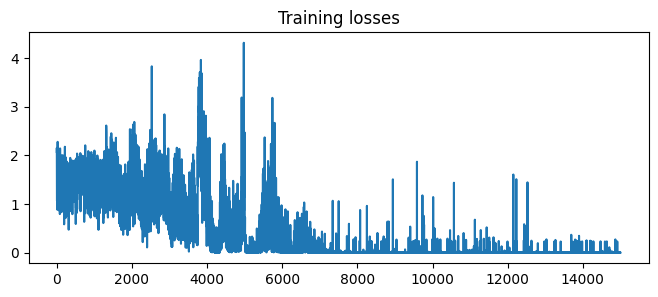

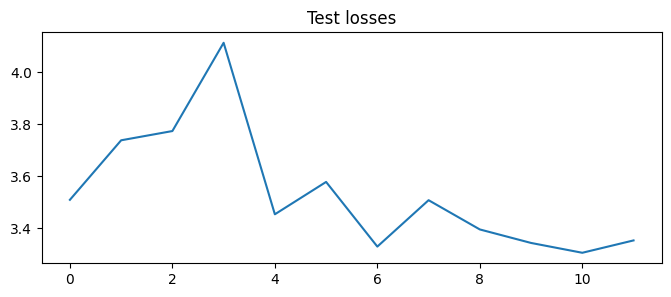

In [29]:
plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.title("Training losses")
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(test_losses)
plt.title("Test losses")
plt.show()